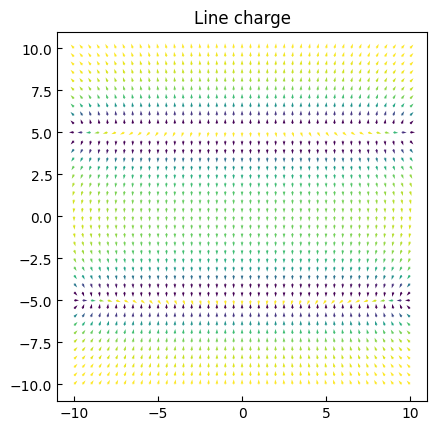

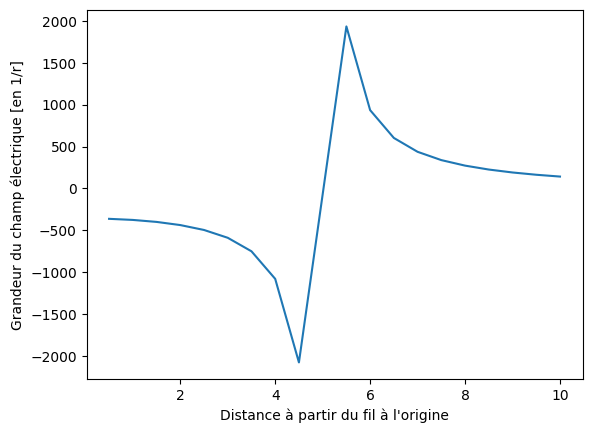

In [13]:
from vectorfield import SurfaceDomain, VectorField2D
import numpy as np
import matplotlib.pyplot as plt

# Je construis le domaine (carré) où je veux évaluer le champ
domain = SurfaceDomain(size=20, N=41)
# Je crée un champ vectoriel (vide, i.e. zero partout)
line_field = VectorField2D(domain)
# J'ajoute plusieurs charges unitaires de x=-10 à x=10    
for x in np.linspace(-10,10, 10001): 
    # La fonction additionne le champ à mesure
    line_field.add_single_charge(xo=x, yo=5, q=1)
    line_field.add_single_charge(xo=x, yo=-5, q=-1)

# Je visualise le champ
line_field.display(title="Line charge")

# Pas simple, mais j'extrais la valeurs du champ sur l'axe X=0 et Y>0 pour le tracer
# On va pouvoir se convaincre que le champ suit une loi de 1/r.
centered = np.logical_and((line_field.domain.X == 0),(line_field.domain.Y > 0)) 
    
plt.plot(line_field.domain.Y[centered], line_field.V[centered])
plt.ylabel("Grandeur du champ électrique [en 1/r]")
plt.xlabel("Distance à partir du fil à l'origine")
plt.show()

# Les données numériques
#for line in zip(line_field.domain.Y[centered], line_field.V[centered]):
#    print(*line)